In [6]:
import os
import re
import PIL
import sys
import sls
import cv2
import json
import time
import glob
import math
import timm
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from glob import glob
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
%config InlineBackend.figure_format = 'retina'
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [2]:
data_dir = '/home/linh/Downloads/Covid-19'

valid_dir = data_dir + "/data"

# Define your transforms for the training and testing sets
data_transforms = {  
    'data':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['data']}

batch_size = 4
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['data']}

class_names = image_datasets['data'].classes
print(class_names)
print(dataset_sizes)
print(device)


### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['data'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['data']))
images.size()

['COVID-19', 'normal', 'pneumonia']
{'data': 15000}
cuda:0
{0: 'COVID-19', 1: 'normal', 2: 'pneumonia'}


torch.Size([4, 3, 224, 224])

# EfficientNet_B0 with image size=224

prediction time for complete in 8226 milisecond
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        10
           1   0.942794  0.968362  0.955407       885
           2   0.939655  0.917508  0.928450       594

    accuracy                       0.941572      1489
   macro avg   0.627483  0.628623  0.627952      1489
weighted avg   0.935210  0.941572  0.938237      1489



/home/linh/.conda/envs/CV/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


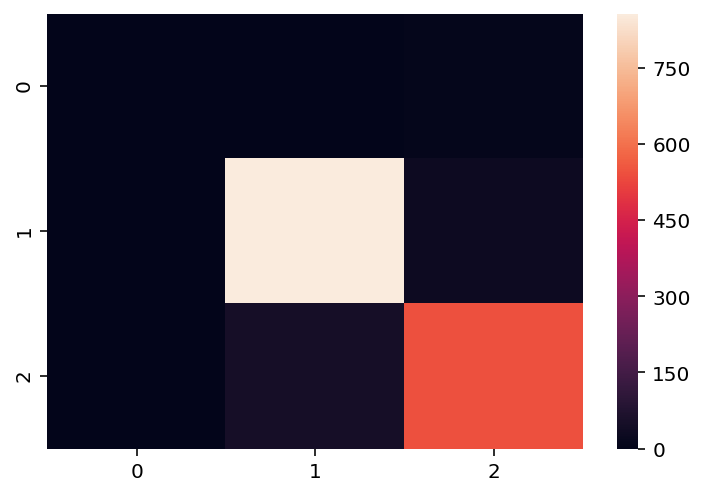

In [3]:
model = timm.create_model('efficientnet_b0', num_classes=4, checkpoint_path='/home/linh/Downloads/Covid-19/weights/EfficientNet_B0.pth')
model.to(device)
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []

for i, (images, labels) in enumerate(data_loader['val']):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())

#set the end time to predict
time_elapsed = round(time.monotonic() * 1000) - since   
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))
#print('Prediction time to complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/EfficientNet_B0.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report

report = classification_report(y_test, y_pred, digits=6)
print(report)

# Modified EfficientNet_B0 with image size = 224

checkpoint loaded
Training complete in 1m 49s
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       108
           1       0.94      0.99      0.97      8851
           2       0.98      0.92      0.95      6041

    accuracy                           0.96     15000
   macro avg       0.97      0.88      0.92     15000
weighted avg       0.96      0.96      0.96     15000



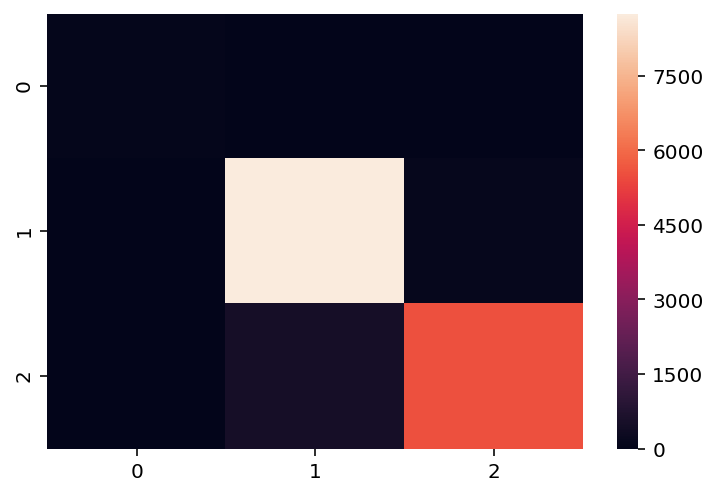

In [7]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b0', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
  model.load_state_dict(checkpoint['model_state_dict'])
  best_model_wts = copy.deepcopy(model.state_dict())
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  best_loss = checkpoint['best_val_loss']
  best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  

since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Modified_EfficienNet_B0_Covid-19_Whole_Data.csv',index=False)

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

# EfficientNet_B4 with image size=380

prediction time for complete in 17995 milisecond
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        10
           1   0.908894  0.946893  0.927504       885
           2   0.930657  0.858586  0.893170       594
           3   0.000000  0.000000  0.000000         0

    accuracy                       0.905306      1489
   macro avg   0.459888  0.451370  0.455169      1489
weighted avg   0.911472  0.905306  0.907578      1489



/home/linh/.conda/envs/CV/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


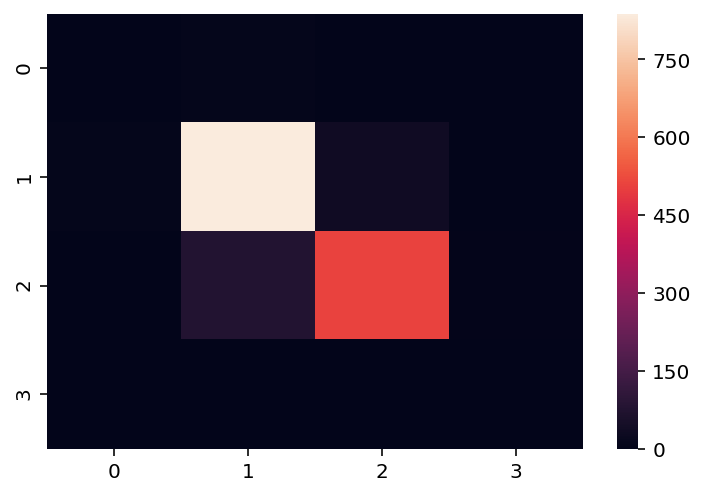

In [3]:
model = timm.create_model('efficientnet_b4', num_classes=4, checkpoint_path='/home/linh/Downloads/Covid-19/weights/EfficientNet_B4.pth')
model.to(device)

since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []

for i, (images, labels) in enumerate(data_loader['val']):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())

#set the end time to predict
time_elapsed = round(time.monotonic() * 1000) - since   
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))
#print('Prediction time to complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/EfficientNet_B4.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=6)
print(report)

# TRseNet_XL with image size=448

prediction time for complete in 33727 milisecond
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000        10
           1   0.590811  0.929944  0.722564       885
           2   1.000000  0.013468  0.026578       594
           3   0.000000  0.000000  0.000000         0

    accuracy                       0.558093      1489
   macro avg   0.397703  0.235853  0.187285      1489
weighted avg   0.750079  0.558093  0.440065      1489



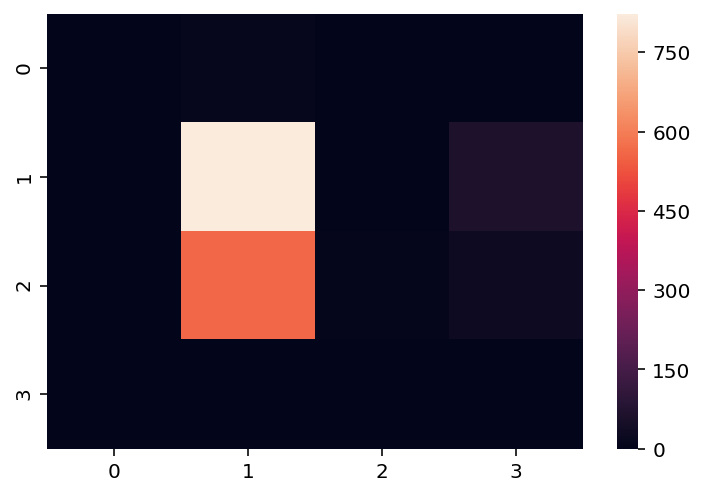

In [8]:
model = timm.create_model('tresnet_xl', num_classes=4, checkpoint_path='/home/linh/Downloads/Covid-19/weights/TResNet_XL.pth')
model.to(device)

since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []

for i, (images, labels) in enumerate(data_loader['val']):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())

#set the end time to predict
time_elapsed = round(time.monotonic() * 1000) - since   
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))
#print('Prediction time to complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/TResNet_XL.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=6)
print(report)

# Ensemble voting of 3 models with image size = 224

In [ ]:
Eff_B0 = timm.create_model('efficientnet_b0', num_classes=4, checkpoint_path='/home/linh/Downloads/Covid-19/weights/EfficientNet_B0.pth')
Eff_B4 = timm.create_model('efficientnet_b4', num_classes=4, checkpoint_path='/home/linh/Downloads/Covid-19/weights/EfficientNet_B4.pth')

In [ ]:

model = timm.create_model('efficientnet_b0', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)
CHECK_POINT_PATH = '/home/linh/Downloads/Covide-19/weights/EfficientNet_B0_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
  model.load_state_dict(checkpoint['model_state_dict'])
  best_model_wts = copy.deepcopy(model.state_dict())
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  best_loss = checkpoint['best_val_loss']
  best_acc = checkpoint['best_val_accuracy']
    
Mod_Eff_B0 = load_model(CHECK_POINT_PATH)  

In [ ]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        self.Eff_B0 = Eff_B0()
        self.Mod_Eff_B0 = Mod_Eff_B0
        self.Eff_B4 = Eff_B4()
        
    def forward(self, x):
        x1 = self.Eff_B0(x)
        x2 = self.Mod_Eff_B0(x)
        x3 = self.Eff_B4(x)
        x = sum([x1, x2, x3]) / 3
        return x
    
model = Ensemble_Model()
model,to(device)
model.eval()

In [ ]:
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []

for i, (images, labels) in enumerate(data_loader['data']):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())

#set the end time to predict
time_elapsed = round(time.monotonic() * 1000) - since   
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))
#print('Prediction time to complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Ensemble_Eff_B0_Eff_B4_Mod_Eff_B0_Whole_Data.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=6)
print(report)